In [96]:
from langchain_core.messages import BaseMessage,HumanMessage,SystemMessage
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from typing import Annotated, Sequence
from langchain.tools import tool

from langchain_google_genai import ChatGoogleGenerativeAI

from typing import Annotated,Union
from pydantic import BaseModel,Field

In [97]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [98]:
class AgentState(BaseModel):
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Tools

In [99]:
@tool
def add_tool(
    a:Annotated[Union[int,float],Field(...,description="integer or float")],
    b:Annotated[Union[int,float],Field(...,description="integer or float")])  -> float:
    """Adding two numbers i.e a and b"""
    return a + b

In [100]:
@tool
def subtract_tool(
    a:Annotated[Union[int,float],Field(...,description="integer or float")],
    b:Annotated[Union[int,float],Field(...,description="integer or float")])  -> float:
    """Subtracting two numbers i.e a and b"""
    return a - b

In [101]:
@tool
def multiple_tool(
    a:Annotated[Union[int,float],Field(...,description="integer or float")],
    b:Annotated[Union[int,float],Field(...,description="integer or float")])  -> float:
    """Multiplying two numbers i.e a and b"""
    return a * b

In [102]:
tools_list = [add_tool,subtract_tool,multiple_tool]
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLE_API_KEY"),
    max_tokens=500 
)
llm = llm.bind_tools(tools_list)

In [103]:
def agent_node(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = llm.invoke([system_prompt]+state.messages)
    return {"messages": [response]}

In [104]:
def should_continue(state: AgentState):
    messages = state.messages
    last_message = messages[-1]
    tool_calls = getattr(last_message, "tool_calls", [])
    if not tool_calls:
        return "end"
    return "continue"

In [105]:
graph = StateGraph(AgentState)

graph.add_node(node="agent",action=agent_node)
graph.add_node(node="tools",action=ToolNode(tools=tools_list))

graph.set_entry_point(key="agent")

graph.add_conditional_edges(source="agent",path=should_continue,
                            path_map={
                                "continue":"tools",
                                "end":"__end__"
                            })

graph.add_edge(start_key="tools",end_key="agent")
graph.set_finish_point(key="agent")


app = graph.compile()

In [120]:
inputs = {"messages":[HumanMessage(
    content="""Add 5 + 7 and then multiply the result by 6 and and lastly  subtract 8.
                Also tell me a joke about langgrap framework.""")]}
llm_response_stream = app.stream(inputs, stream_mode="values")

In [ ]:
## custom function for display messages
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        message.pretty_print()
print_stream(llm_response_stream)

================================ Human Message =================================

Add 5 + 3 and then multiply the result by 6 and and lastly  subtract 8.
                Also tell me a joke about langgrap framework.
================================== Ai Message ==================================
Tool Calls:
  add_tool (28b4603a-a0f9-4f69-9de0-87a06d5842e3)
 Call ID: 28b4603a-a0f9-4f69-9de0-87a06d5842e3
  Args:
    a: 5.0
    b: 3.0
================================= Tool Message =================================
Name: add_tool

8.0
================================== Ai Message ==================================
Tool Calls:
  multiple_tool (deb16bca-6a1a-42a7-a5b2-5e3297ce6a91)
 Call ID: deb16bca-6a1a-42a7-a5b2-5e3297ce6a91
  Args:
    a: 8.0
    b: 6.0
================================= Tool Message =================================
Name: multiple_tool

48.0
================================== Ai Message ==================================
Tool Calls:
  subtract_tool (9326cb5f-2564-42dd-81

In [108]:
## print the only last message of the llm
result = app.invoke(inputs)
result["messages"][-1].content.split("\n")

['The result of your calculations is 40.',
 '',
 'Why did the LangChain framework break up with the other frameworks?',
 'Because it felt like it was always doing all the heavy "chaining"!']

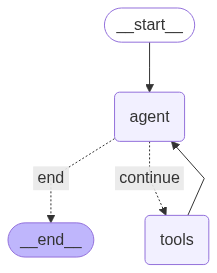

In [109]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))